## Прикладная статистика в машинном обучении

### Семинар 4: EM-алгоритм

#### Постановка задачи.

Сначала вспомним постановку задачи. 
Как и в предыдущих задачах, мы хотим максимизировать логарифм функции правдоподобия $\ell(x | \theta)$, чтобы найти оценку вектора параметров $\theta$. 
Однако бывает так, что эта функция имеет такой вид, что максимизировать сложно (например, если под логарифмом оказывается сумма). 
Идея EM-алгоритма состоит в том, чтобы ввести латентные переменные $z$ и использовать совместное распределение $p(X, Z)$ для нахождения $\hat{\theta}$.

#### EM-алгоритм в общем виде.

>  **Инициализация:** задать начальные условия на $\theta_{old}$.

> **E.1-шаг:** найти условное распределение латентных переменных $p(Z | X, \theta_{old})$.

> **E.2-шаг:** построить функцию $Q(\theta, \theta_{old}) = E_{Z | X, \theta}(\ell(x, z | \theta) | x, \theta_{old})$.

> **M-шаг:** максимизировать $Q$ по $\theta$.

> Далее повторять E- и M-шаги до сходимости.

#### Обоснование EM-алгоритма.

Для обоснования ЕМ-алгоритма и понимания обозначений рассмотрим пример: 

Пусть $X_1, X_2, \ldots, X_n$ $\sim f(x, | \theta)$, где $f$ -- какая-то функция плотности, $\theta$ -- вектор неизвестных параметров этой плотности.

Пусть латентные переменные принимают всего два значения: $Z \in \{0, 1\}$ -- с вероятностями $P(Z = 0) = p_1$, $P(Z = 1) = 1-p_1$.

Тогда $\ell(x | \theta) = \sum_i \ln f(x_i | \theta)$.

Заметим, что 

$$
\ell(x | \theta) = \sum_i \ln f(x_i | \theta) = \sum_i \sum_j P(Z = j)\ln f(x_i | \theta) = 
\sum_i \sum_j P(Z = j)\ln \dfrac{f(x_i, Z = j | \theta)}{P(Z = j | x_i, \theta)} = 
$$

(чтобы понять последний переход, распишите знаменатель выражения под логарифмом по формуле условной вероятности)

$$
= \sum_i \sum_j P(Z = j)\ln \dfrac{f(x_i, Z = j | \theta) P(Z = j)}{P(Z = j | x_i, \theta)P(Z = j)} = 
$$

$$
= \sum_i \sum_j P(Z = j) \ln \dfrac{f(x_i, Z = j | \theta)}{P(Z = j)} + \sum_i \sum_j P(Z = j) \ln \dfrac{P(Z = j)}{P(Z = j | x_i, \theta)} =
$$

$$
M(P(Z = j), \theta) + D_{KL}[P(Z = j) || P(Z = j | x_i, \theta)].
$$

Так как $D_{KL} \ge 0$, то $M(P(Z = j), \theta)$ является нижней оценкой на логарифм правдоподобия. Идея EM-алгоритма состоит в том, чтобы поочерёдно максимизировать $M(P(Z = j), \theta)$ по $P(Z = j)$ (на E-шаге) и по $\theta$ (на M-шаге).

**E-шаг.**

Максимизируем $M(P(Z = j), \theta)$ по $P(Z = j)$.

Так как $\ell(x | \theta)$ не зависит от $P(Z = j)$, то максимум $M(P(Z = j), \theta)$ по $P(Z = j)$ будет достигнут, когда $D_{KL}$ минимальна. 

Минимальная $D_{KL}(A || B)$ равна 0, и это достигается, когда $A || B$. Из этого делаем вывод, что на E-шаге мы устанавливаем

$$
P(Z = j) := P(Z = j | x_i, \theta^{old}).
$$

**M-шаг.**

Максимизируем $M(P(Z = j), \theta)$ по $\theta$. Распишем $M$ ещё раз:

$$
M = \sum_i \sum_j P(Z = j) \ln \dfrac{f(x_i, Z = j | \theta)}{P(Z = j)}
$$


Заметим, что знаменатель подлогарифмического выражения не зависит от $\theta$. Выбросим его и заменим $P(Z = j)$ на результат, полученный нами на E-шаге:

$$
M = \sum_i \sum_j P(Z = j | x_i, \theta^{old}) \ln f(x_i, Z = j | \theta) = \sum_i E_{Z | x_i, \theta_{old}}(\ln f(x_i, Z = j | \theta)) := Q(\theta, \theta^{old}).
$$

Далее мы максимизируем $Q$ по по $\theta$, обновляем $\theta$ на аргмаксимум $Q$, и возвращаемся к E-шагу.

#### Обозначения.

Теперь соотнесём обозначения из общей постановки EM-алгоритма с теми, что мы получили в примере.

$p(Z)$ -- это безусловное распределение $Z$. По сути, это массив размера $1\times k$, где $k$ -- число значений $Z$.

$p(Z | X, \theta_{old})$ -- это условное распределение $Z$ при условии выборки. По сути, это массив размера $N\times k$, где $N$ -- размер выборки, $k$ -- число значений $Z$. Каждая строчка есть вектор вероятностей того, что на данном наблюдении $Z$ равно соответсвующему значению.

$E_{Z | X, \theta}(\cdot)$ -- это сумма матожиданий $\sum_i E_{Z | x_i, \theta}$ по всем наблюдениям выборки.

$p(\cdot)$ -- распределение того, что стоит в скобках. Эта функция может оказаться функцией вероятности или функцией плотности в зависимости от контекста.

---

#### Пример с лекции: задача о кластеризации (разделение смеси распределений).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.random.seed(123)

Пример:

(array([ 1.,  1.,  5.,  8., 19., 30., 22.,  5.,  8.,  1.]),
 array([0.76894499, 1.35188089, 1.93481678, 2.51775267, 3.10068857,
        3.68362446, 4.26656035, 4.84949625, 5.43243214, 6.01536803,
        6.59830393]),
 <a list of 10 Patch objects>)

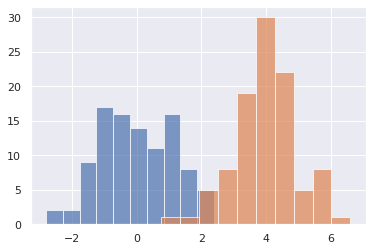

In [2]:
y1 = np.random.normal(0, 1, 100)
y2 = np.random.normal(4, 1, 100)
plt.hist(y1, alpha = 0.7)
plt.hist(y2, alpha = 0.7)

In [3]:
x = np.array([5, 6, 2, 1, 1, 3, 7, 10])

**Постановка задачи.** 

Пусть мы точно знаем, что наблюдения принадлежат одному из двух кластеров. Пусть в первом кластере наблюдения берутся из нормального $\mathcal{N}(\mu_1, \sigma_1^2)$ распределения, а во втором -- из нормального $\mathcal{N}(\mu_2, \sigma_2^2)$ распределения. Предположим, что все наблюдения независимы, и вероятность того, что наблюдение относится к первому кластеру, равна $p_1$.

In [4]:
# Определите вектор параметров для данной задачи и задайте начальные условия
# theta = (mu_1, sigma2_1, mu2, sigma2_2, p_1)
# (воспользовались эвристикой)
theta = np.array([np.min(x), (np.max(x) - np.min(x)) / 2, np.max(x), (np.max(x) - np.min(x)) / 2, 1/2])
theta

array([ 1. ,  4.5, 10. ,  4.5,  0.5])

**Определение латентных переменных.**

$z \in \{1, 2\}$ -- номер кластера.

Вспомним, что у нас есть обозначение $p_1 = P(z = 1)$ -- вероятность отнести наблюдение к первому кластеру.

**E.1-шаг.**

Найти условное распределение латентных переменных $p(Z | X, \theta_{old})$. Для данной задачи это означает, что мы должны получить массив $8\times2$ (8 наблюдений, 2 значения $z$). Нам достаточно найти только один столбец массива -- этот столбец будет размера $8\times1$ (то есть вероятность того, что $z = 1$) -- потому что второй столбец определяется однозначно как ($1 - $ первый столбец).

По формуле условной вероятности:
$$
p(z | x, \theta_{old}) = \dfrac{p(z, x | \theta_{old})}{p(x | \theta_{old})}
$$

и
$$
p(x | z, \theta_{old}) = \dfrac{p(x, z | \theta_{old})}{p(z)}
$$

Тогда
$$
P(z_i = 1 | x_i, \theta_{old}) = \dfrac{p(z_i = 1, x_i | \theta_{old})}{f(x_i | \theta_{old})}
$$

$$
= \dfrac{f(x_i | z_i = 1, \theta_{old})p_1}{p_1f(x_i | z_i = 1, \theta_{old}) + (1-p_1)f(x_i | z_i = 2, \theta_{old})}
$$

In [5]:
# Задайте плотность x
def f(x, mu, sigma2):
    return 1 / np.sqrt(2 * np.pi * sigma2) * np.exp(-1/2 * 1/sigma2 * (x - mu)**2)

In [6]:
# Рассчитайте распределение латентных переменных на наших данных
p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[4] / (theta[4] * f(x, mu = theta[0], sigma2 = theta[1]) + 
                                                       (1-theta[4]) * f(x, mu = theta[2], sigma2 = theta[3]))

In [7]:
p_z_1

array([7.31058579e-01, 2.68941421e-01, 9.99088949e-01, 9.99876605e-01,
       9.99876605e-01, 9.93307149e-01, 4.74258732e-02, 1.23394576e-04])

**E.2-шаг.**

Постройте функцию $Q(\theta, \theta_{old}) = E_{Z | X, \theta}(\ell(x, z | \theta) | x, \theta_{old})$.

По формуле условной вероятности:
$$
p(x, z | \theta) = p(x | \theta, z) \times p(z)
$$

$$
Q(\theta, \theta_{old}) = \sum_i P(z_i = 1 | x, \theta_{old})[\ln f(x_i | \theta) + \ln p_1] + (1 - P(z_i = 1 | x, \theta_{old})[\ln f(x_i | \theta) + \ln(1-p_1)].
$$

**M-шаг.**

Выведите формулы для максимизации $Q$.

$$
Q'_{\mu_1} = \sum_i P(z_i = 1 | x, \theta_{old}) \dfrac{(x_i - \mu_1)}{\sigma_1^2}
$$

$$
\mu_1^{new} = \dfrac{\sum_i P(z_i = 1 | x, \theta_{old}) x_i}{\sum_i P(z_i = 1 | x, \theta_{old})}
$$

Аналогично,

$$
\mu_2^{new} = \dfrac{\sum_i (1 - P(z_i = 1 | x, \theta_{old})) x_i}{\sum_i (1 - P(z_i = 1 | x, \theta_{old}))}
$$

Далее:

$$
Q'_{\sigma_1^2} = \sum_i P(z_i = 1 | x, \theta_{old}) (-\dfrac{1}{2\sigma^2_1} + \dfrac{1}{2}\dfrac{(x_i - \mu)^2}{\sigma_1^4})
$$

$$
\sigma_1^{2, new} = \dfrac{\sum_i (x_i - \mu)^2 P(z_i = 1 | x, \theta_{old})}{\sum_i P(z_i = 1 | x, \theta_{old})}
$$

Аналогично для $\sigma_2^{2, new}$.

Далее:

$$
Q'_{p_1} = \sum_i P(z_i = 1 | x, \theta_{old}) \dfrac{1}{p_1} - (1 - P(z_i = 1 | x, \theta_{old})) \dfrac{1}{1 - p_1}
$$

$$
p_1^{new} = \dfrac{\sum_i P(z_i = 1 | x, \theta_{old})}{n}
$$

In [8]:
# Реализуйте формулы для одного M-шага
mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)

In [9]:
mu_2 = np.sum((1-p_z_1) * x) / np.sum(1-p_z_1)

In [10]:
sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)

In [11]:
sigma2_2 = np.sum((x - mu_2) ** 2 * (1 - p_z_1))/ np.sum(1 - p_z_1)

In [12]:
p1 = np.sum(p_z_1) / len(x)

In [13]:
theta_new = np.array([mu_1, sigma2_1, mu_2, sigma2_2, p1])

In [14]:
theta

array([ 1. ,  4.5, 10. ,  4.5,  0.5])

In [15]:
theta_new

array([2.49618283, 2.74390095, 7.57355004, 3.36811658, 0.62996232])

**Сбор EM-алгоритма в функцию.**

На каждом шаге будем дополнительно рассчитывать значение $Q$. Для этого определим дополнительные функции:

In [16]:
# Логарифм функции плотности x
def lnf(x, mu, sigma2):
    return -1/2 * np.log(2 * np.pi * sigma2) - 1/2 * (x - mu) ** 2 / sigma2

In [17]:
def Q_f(x, theta, p_z_1):
    ell1 = lnf(x, theta[0], theta[1]) + np.log(theta[4])
    ell2 = lnf(x, theta[2], theta[3]) + np.log(1 - theta[4])
    return np.sum(p_z_1 * ell1 + (1 - p_z_1) * ell2)

Запустим цикл:

In [18]:
def EM(x, theta):
    
    Q_history = []
    
    for i in range(100):
        
        # E-step
        p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[4] / (theta[4] * f(x, mu = theta[0], sigma2 = theta[1]) + 
                                                       (1-theta[4]) * f(x, mu = theta[2], sigma2 = theta[3]))
        
        Q_history.append(Q_f(x, theta, p_z_1))
        
        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < 1e-4:
                break
        
        # M-step
        mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)
        mu_2 = np.sum((1-p_z_1) * x) / np.sum(1-p_z_1)
        sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)
        sigma2_2 = np.sum((x - mu_2) ** 2 * (1-p_z_1))/ np.sum(1 - p_z_1)
        p1 = np.sum(p_z_1) / len(x)
        theta_new = np.array([mu_1, sigma2_1, mu_2, sigma2_2, p1])
        
        theta = theta_new
    
    return (theta, Q_history)

In [19]:
theta, Q = EM(x, theta)

In [20]:
theta

array([1.61403194, 0.58183979, 6.49747214, 5.07879106, 0.43462642])

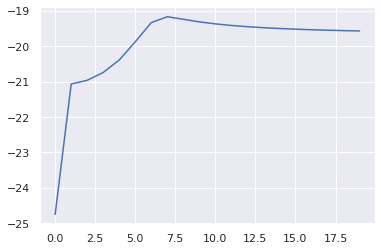

In [21]:
plt.plot(Q)

Об объяснении такой динамики можно прочитать [здесь](https://stats.stackexchange.com/questions/341173/em-algorithm-seems-to-work-but-q-is-not-monotonic-possible-reasons).

#### Тестирование EM-алгоритма на случайных данных.

In [22]:
np.random.seed(1234)
x1 = np.random.normal(0, 1, 100)
x2 = np.random.normal(4, 0.5, 100)

x = np.hstack((x1, x2))
np.random.shuffle(x)

theta = np.array([np.min(x), (np.max(x) - np.min(x)) / 2, np.max(x), (np.max(x) - np.min(x)) / 2, 1/2])
theta

array([-3.56351666,  4.37320049,  5.18288431,  4.37320049,  0.5       ])

In [23]:
theta, Q = EM(x, theta)

In [24]:
theta

array([0.04256547, 1.01503608, 3.97557634, 0.24095056, 0.50103058])

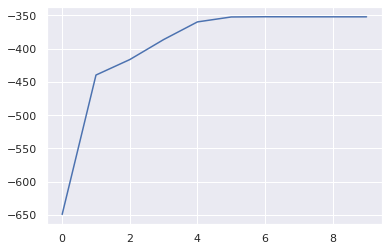

In [25]:
plt.plot(Q)